In [1]:
# Dicoding Course "Belajar Pengembangan Machine Learning" 2nd Project: Time-Series

# Weather Analaysis (or something)

# Hanif Rachmadani on 15/07/2021.

# Dataset used : https://www.kaggle.com/mahirkukreja/delhi-weather-data

In [2]:
# TF & Data-prepping Libraries Import

from google.colab import files

import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split

In [3]:
# Dataset Download

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d mahirkukreja/delhi-weather-data

!mkdir delhi-weather-data
!unzip delhi-weather-data.zip -d delhi-weather-data
!ls delhi-weather-data

Saving kaggle.json to kaggle.json
kaggle.json
  0% 0.00/1.00M [00:00<?, ?B/s]
100% 1.00M/1.00M [00:00<00:00, 66.8MB/s]
Archive:  delhi-weather-data.zip
  inflating: delhi-weather-data/testset.csv  
testset.csv


In [4]:
# Initial Dataframe Loading

df_initial = pd.read_csv('delhi-weather-data/testset.csv', sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')

df_initial.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [5]:
# Dataframe Prepping

df_humid = pd.concat([df_initial['datetime_utc'],df_initial['_hum']],axis=1)

df_humid.rename(columns={'datetime_utc':'date','_hum':'humidity'},inplace='true')

df_humid['date'] = pd.to_datetime(df_humid['date'])

print(df_humid.isnull().sum())


date          0
humidity    757
dtype: int64


In [6]:
# Fill NA Values

df_humid['humidity'].fillna(df_humid['humidity'].mean(), inplace=True)
print(df_humid.isnull().sum())

date        0
humidity    0
dtype: int64


In [7]:
# Final Dataframe

df_humid.head()

,date,humidity
0,1996-11-01 11:00:00,27.0
1,1996-11-01 12:00:00,32.0
2,1996-11-01 13:00:00,44.0
3,1996-11-01 14:00:00,41.0
4,1996-11-01 16:00:00,47.0


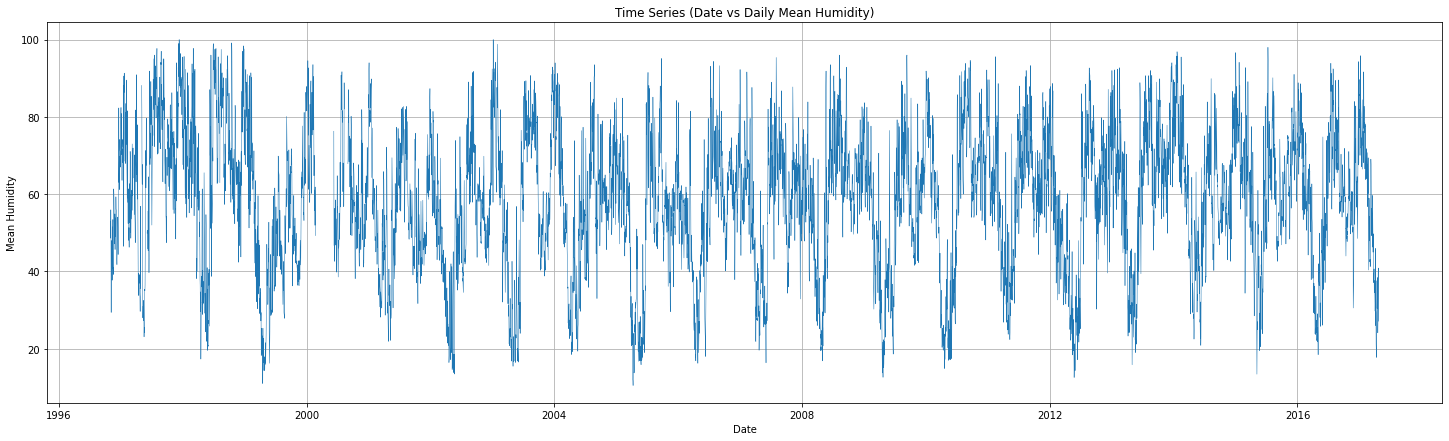

In [8]:
# Daily Average Humidity (Reference Only)  

import matplotlib.pyplot as plt

df_avhumid = df_humid.copy()
df_avhumid.set_index('date',inplace=True)
df_avhumid = df_avhumid.resample('D').mean()
df_avhumid.reset_index(level=0, inplace=True)

plt.figure(figsize=(25, 7))
plt.plot(df_avhumid['date'],df_avhumid['humidity'], linewidth=.5)
plt.grid()
plt.title("Time Series (Date vs Daily Mean Humidity)")
plt.xlabel('Date')
plt.ylabel('Mean Humidity')
plt.show()

In [9]:
# Windowing Function (Based from Module)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
# Train Test Split

from sklearn.model_selection import train_test_split

date = df_humid['date'].values
humid = df_humid['humidity'].values

x_train, x_test, y_train, y_test = train_test_split(humid, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

data_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
data_val = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)


80792 20198


In [11]:
# Model Design

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss='huber',
              optimizer=optimizer,
              metrics=['mae'])


In [12]:
# Callback Function Declaration

target_mae = (df_humid['humidity'].max() - df_humid['humidity'].min()) * 10/100  # MAE Target 10% Data
print(target_mae)

class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('mae')<target_mae:  
      print("MAE Target of <10% Total Data Scale on Both Datasets Reached, Stopping Training...")
      self.model.stop_training = True


23.9


In [13]:
# Model Training

history = model.fit(
            data_train,
            validation_data=data_val,
            epochs=50,                                 # 50 Maximum Epoch (Arbitratry)
            callbacks=[modelCallback()],              # Callback
            verbose='auto')


Epoch 1/50
808/808 [==============================] - 42s 41ms/step - loss: 28.9121 - mae: 29.4083 - val_loss: 17.6367 - val_mae: 18.1316
Epoch 2/50
808/808 [==============================] - 32s 39ms/step - loss: 15.4376 - mae: 15.9312 - val_loss: 16.9762 - val_mae: 17.4710
MAE Target of <10% Total Data Scale on Both Datasets Reached, Stopping Training...


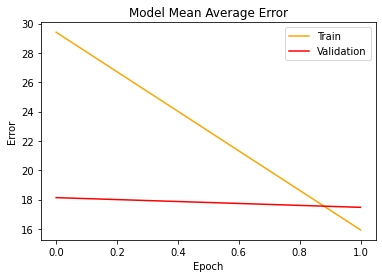

In [14]:
# Pyplot Import

import matplotlib.pyplot as plt

# Loss & Accuracy Graph

plt.plot(history.history['mae'], color="orange")
plt.plot(history.history['val_mae'], color="red")
plt.title('Model Mean Average Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()
